<font size="+8"><center>
    Notebook for PBMC data
</center></font>
<font size="+2"><center>
    Meichen Fang, Gennady Gorin, and Lior Pachter
</center></font>

# Preparation and exploratory data analysis
## Load packages

In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)
from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixtureSS, PoissonMixture, GammaPoissonMixture
from RADOM.utils import *
from RADOM.plotting import *

2023.09.01


In [3]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
import gget

In [4]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    plt.loglog(A[msk],A[msk],'k')
    plt.plot(A[msk],B[msk],'.', \
           label="CCC="+str(np.round(CCC(X,Y),2))\
             +"\nPearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2)));
    plt.legend(fontsize=15)

In [5]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '30'
legend_font = '24'
title_font = '36'

## Load counts

In [6]:
alldata = sc.read('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom',validate=False)
alldata

AnnData object with n_obs × n_vars = 11756 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [7]:
clusters = pd.read_csv('/home/tchari/metadata/pbmc_10k_v3_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
clusters

,Barcode,Cluster
0,AAACCCAAGCGCCCAT-1,1
1,AAACCCAAGGTTCCGC-1,2
2,AAACCCACAGAGTTGG-1,2
3,AAACCCACAGGTATGG-1,1
4,AAACCCACATAGTCAC-1,3
...,...,...
11764,TTTGTTGGTGTCATGT-1,2
11765,TTTGTTGGTTTGAACC-1,1
11766,TTTGTTGTCCAAGCCG-1,1
11767,TTTGTTGTCTTACTGT-1,1


In [8]:
cluster_bc = np.array([bc[:-2] for bc in clusters['Barcode']],dtype=str)
bcs = alldata.obs['barcode'][alldata.obs['barcode'].isin(cluster_bc)]
alldata = alldata[alldata.obs['barcode'].isin(cluster_bc)]
alldata

View of AnnData object with n_obs × n_vars = 11536 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [9]:
idx = []
for bc in bcs:
    idx.append(np.where(cluster_bc == bc)[0][0])

In [10]:
clusters['Cluster'][np.array(idx)]

0        1
1        2
2        2
3        1
4        3
        ..
11764    2
11765    1
11766    1
11767    1
11768    4
Name: Cluster, Length: 11536, dtype: int64

In [11]:
adata = alldata[clusters['Cluster'][np.array(idx)]==1]

## Gene variance

0.13272092 0.14107434


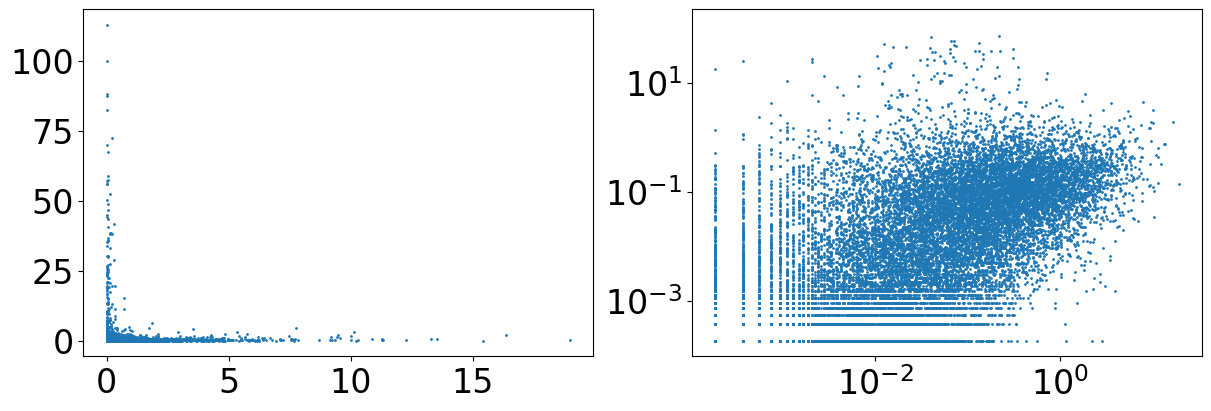

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

In [13]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.001) & (adata.layers["unspliced"].toarray().mean(0) > 0.001)

U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.25607338365238586
s estimated by normalized covariance of total S counts = 0.5101397736809037
s estimated by normalized covariance of total counts = 0.3145641834844203
s estimated by total counts = 0.1743888916842523


In [18]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.001) & (adata.layers["unspliced"].toarray().mean(0) > 0.001)

X = adata.X.toarray()[:,idx]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]

s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total counts = 0.5101397736809037
s estimated by total counts = 0.23677976310565285


In [19]:
a=1
sp=s1

X_var = np.var(X,axis=0)
for i in range(5):
    Pgene_mask = (X_mean > 0.01) & (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   
    P = X[:,Pgene_mask]
    n,p = P.shape
    P_cov = np.cov(P,rowvar=False)
    P_mean = np.mean(P,axis=0)
    P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
    sp = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
    print(Pgene_mask.mean(),"s:", str(sp))

0.5500936329588015 s: 0.2505720093038868
0.46925717852684146 s: 0.24482523719050625
0.46668227215980024 s: 0.24483422268746843
0.46668227215980024 s: 0.24483422268746843
0.46668227215980024 s: 0.24483422268746843


Text(0.02, 0.5, 'CV$^2$')

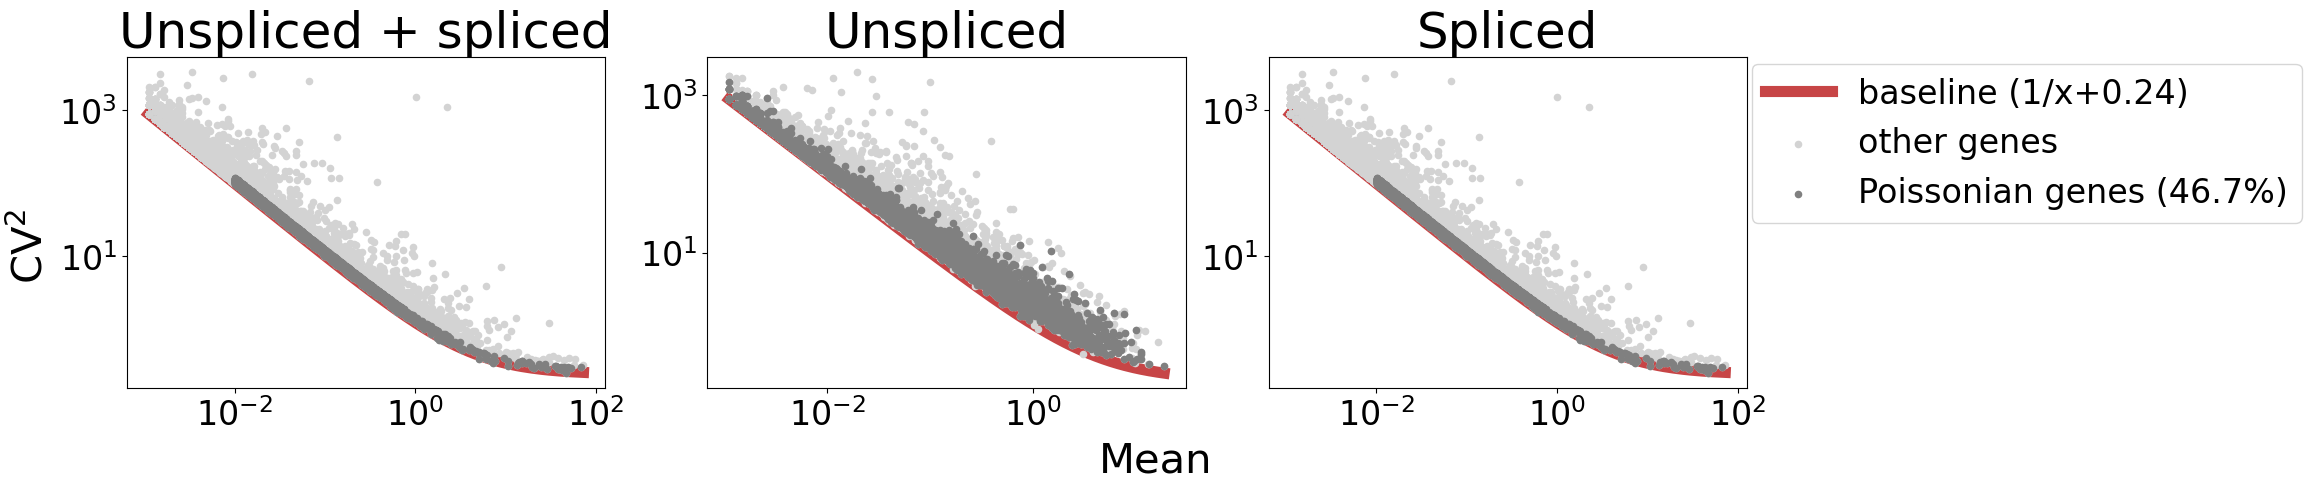

In [21]:
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

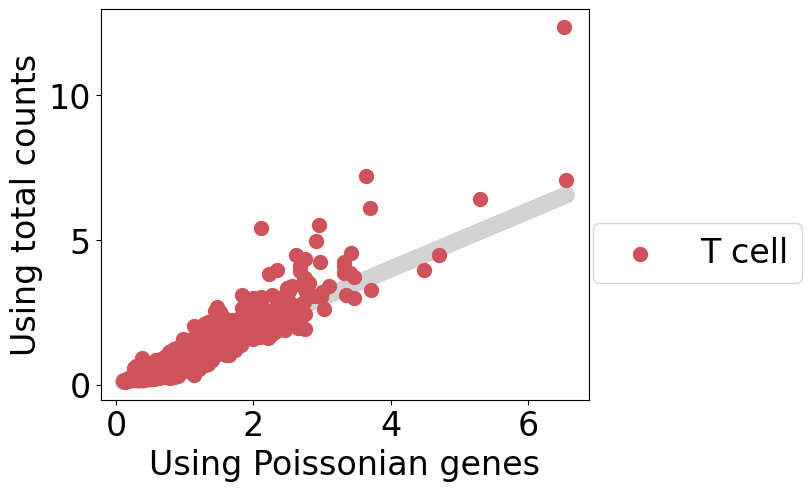

In [24]:
rd = (U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean()
rd_ = X_total/X_total.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
ax.scatter(rd,rd_,color='#ce535a',alpha=1,s=100,label='T cell')
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0.3),fontsize=legend_font)

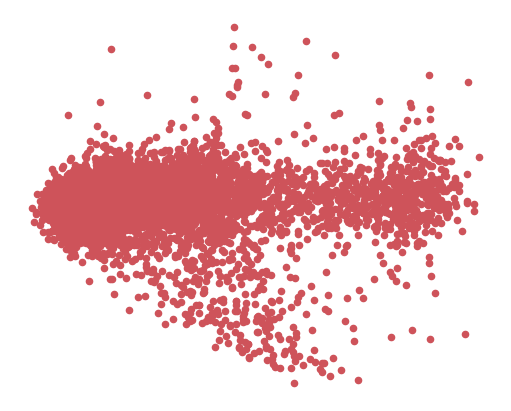

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X.toarray()/rd[:,None]))

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(x[:,0],x[:,1],color='#ce535a',s=20);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

## Select genes

In [26]:
var_threshold = 1.5
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.02) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

211

In [27]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

211

Text(0.02, 0.5, 'Variance')

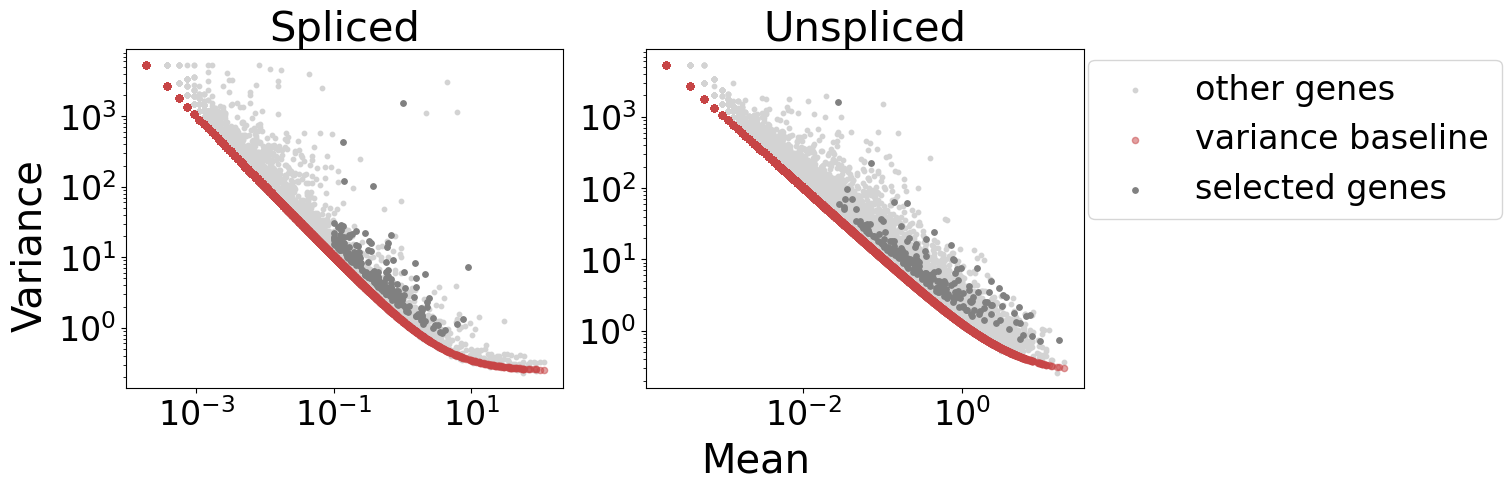

In [28]:
fig, ax = plt.subplots(1,2,figsize=(15,4.8))

ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, s=15, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Spliced',fontsize=label_font)


ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, s=15, c='gray', label='selected genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc=(1.01,0.5),fontsize=legend_font)
ax[1].set_title('Unspliced',fontsize=label_font)
fig.supxlabel('Mean')
fig.supylabel('Variance')

In [27]:
fitted_idx = adata.var_names.isin(fitted_genes)

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X.mean((0,1)))
X.shape

[0.92432711 0.72676842]


(5375, 213, 2)

## Mixtures fitting

1 -498.8769464821549 -498.95620229610836 -499.2173309380969
2 -449.77136562558957 -449.89043539303145 -450.282741334047
3 -435.30107372056807 -435.4599574414983 -435.98344068154097
4 -427.9897741915694 -428.188471865988 -428.8431324050577
5 -422.08895732333167 -422.32746895123864 -423.11330678933547
6 -419.00735234206604 -419.2856779234614 -420.20269306058526


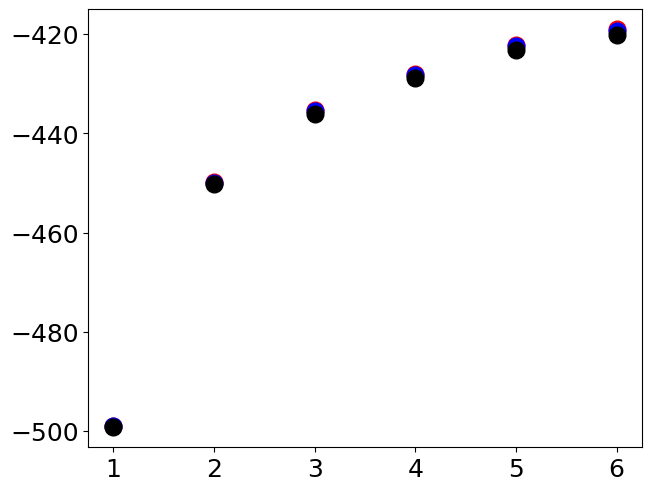

In [28]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixtureSS(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=5,n_init=10)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X),color='b')
    plt.scatter(nc,PM.compute_BIC(X),color='k')
    print(nc,PM.compute_lower_bound(X),PM.compute_AIC(X),PM.compute_BIC(X))

In [35]:
PM = PoissonMixtureSS(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=10)
PM.weights

array([0.46520388, 0.39166482, 0.1431313 ])

In [36]:
PM_elbo = elbo
PM_elbo

-435.2719400712865

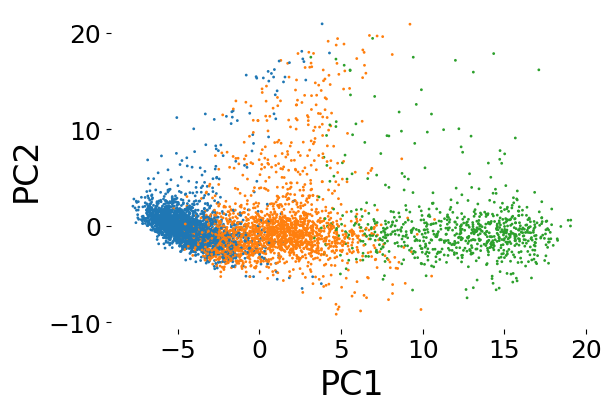

In [37]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)

# Trajectory fitting

In [86]:
with open('results/PBMC.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    data = pickle.load(f)

trajs = data['ri']

In [40]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
params={'r':rd,"lambda_tau":0,"lambda_a":0}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=101,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [84]:
data = {'ri':trajs}

In [85]:
with open('results/PBMC.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [87]:
corrs = []
AICs = []
for traj in trajs:
    AICs.append( traj.compute_AIC(traj.X, standard=True) )
    
traj = trajs[np.argmax(elbos)]
right_t = traj.Q[:,0] @ trajs[0].t
for traj_ in trajs:
    t_hat = traj_.Q[:,0] @ traj_.t
    corrs.append(pearsonr(right_t,t_hat)[0])

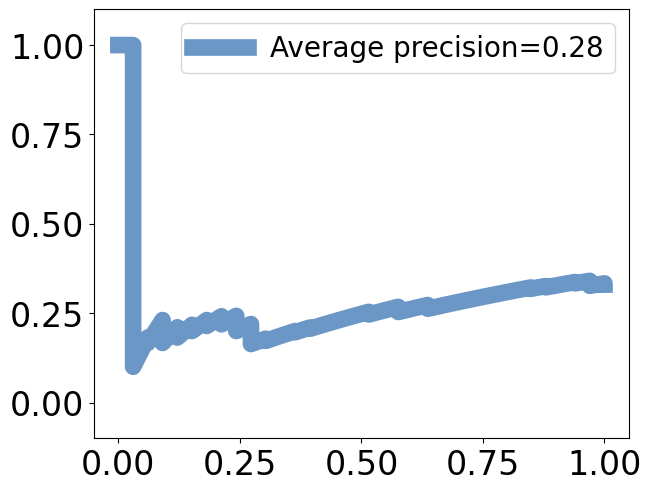

In [119]:
from sklearn.metrics import average_precision_score, precision_recall_curve

is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=elbos)
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="Average precision="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=20)

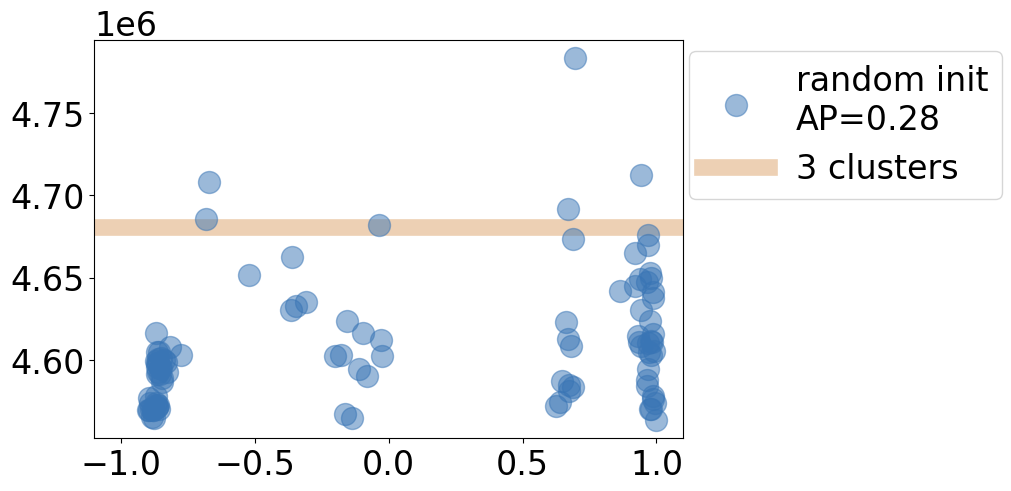

In [120]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(PM.compute_AIC(traj.X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='3 clusters')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.6),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

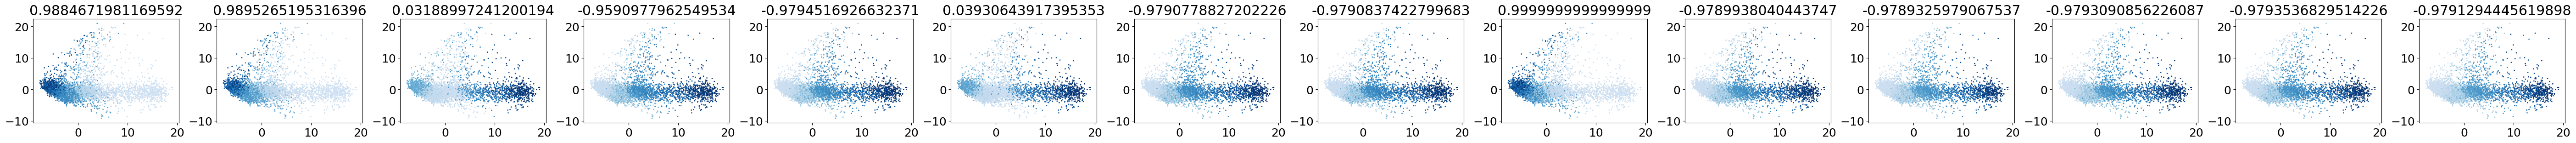

In [58]:
traj_idx = np.where(np.array(elbos)>-425)[0]
fig, ax = plt.subplots(1,len(traj_idx),figsize=(4*len(traj_idx),3))
for i,ii in enumerate(traj_idx):
    traj = trajs[ii]
    #print(traj.tau)
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    ax[i].scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y,s=1);
    ax[i].set_title(corrs[ii])

[0.         1.14999133 2.        ]


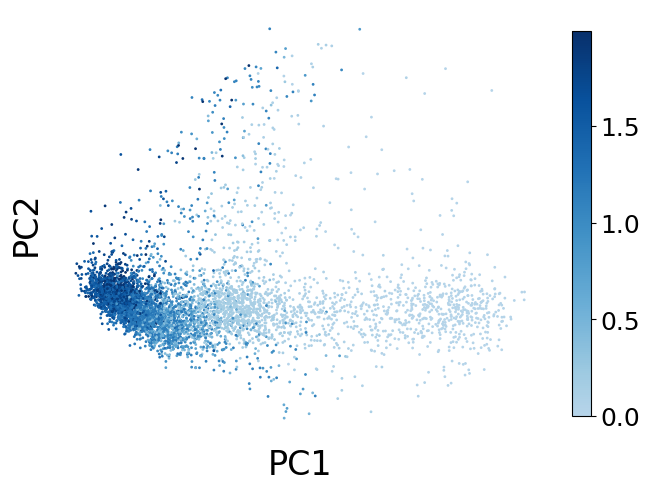

In [48]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.3, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y,s=1);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

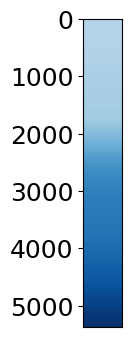

In [44]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
cluster =traj.Q[:,0]@traj.t
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_y)
ax.set_xticks([])

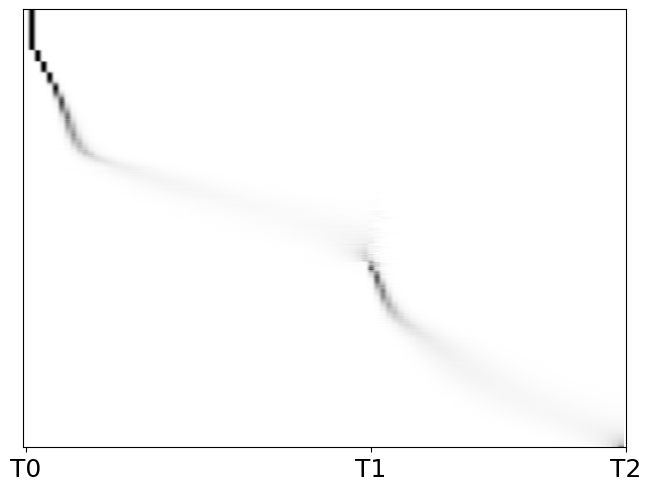

In [46]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['T0', 'T1', 'T2']
ax.set_xticks(traj.tau/traj.tau[-1]*traj.m)
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

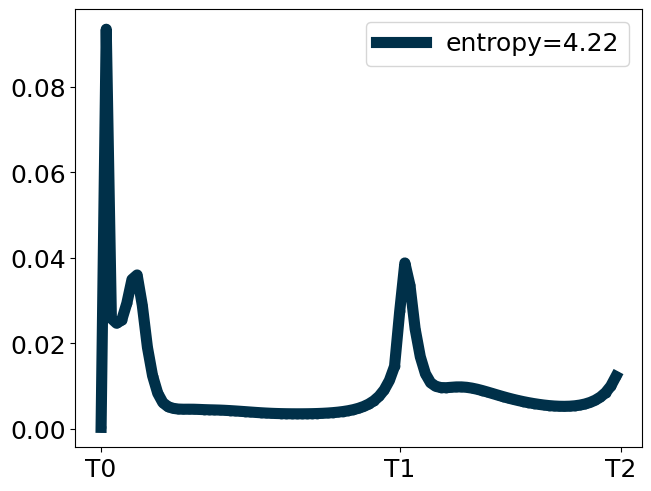

In [47]:
ax = plt.subplot()
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#003049",linewidth=8,\
        label="entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = ['T0', 'T1', 'T2']
ax.set_xticks(traj.tau/traj.tau[-1]*traj.m)
ax.set_xticklabels(x_label_list);
ax.legend()

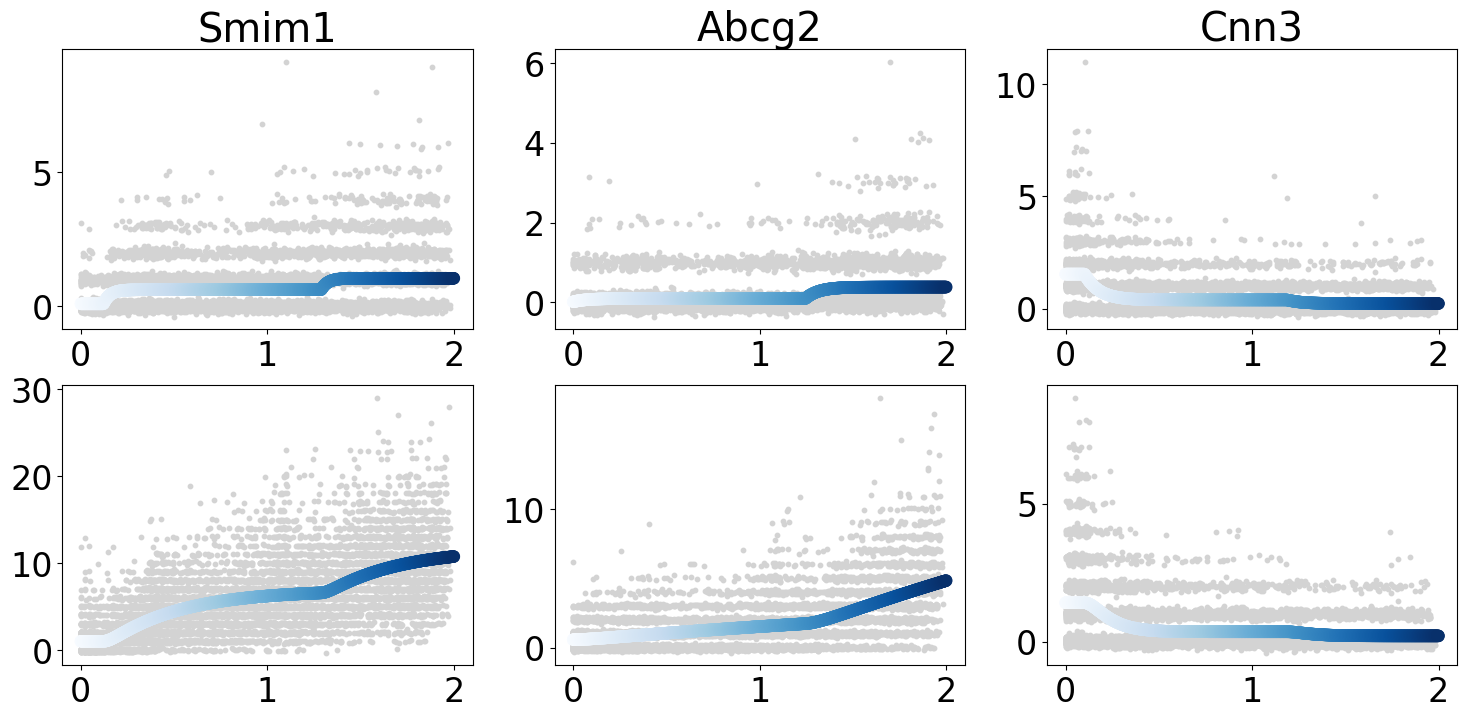

In [213]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

In [214]:
traj.theta[plot_idx]

array([[9.23539912e-02, 6.20488578e-01, 1.04651300e+00, 1.21212121e-01,
        1.28859792e+00, 2.85218164e+01, 2.56045844e+00],
       [1.10701102e-02, 9.23852614e-02, 3.80857383e-01, 0.00000000e+00,
        1.24496376e+00, 1.41167870e+01, 2.70915786e-01],
       [1.53592086e+00, 3.87331447e-01, 2.25367992e-01, 1.01770001e-01,
        1.18783647e+00, 1.28713314e+01, 1.40488904e+01]])

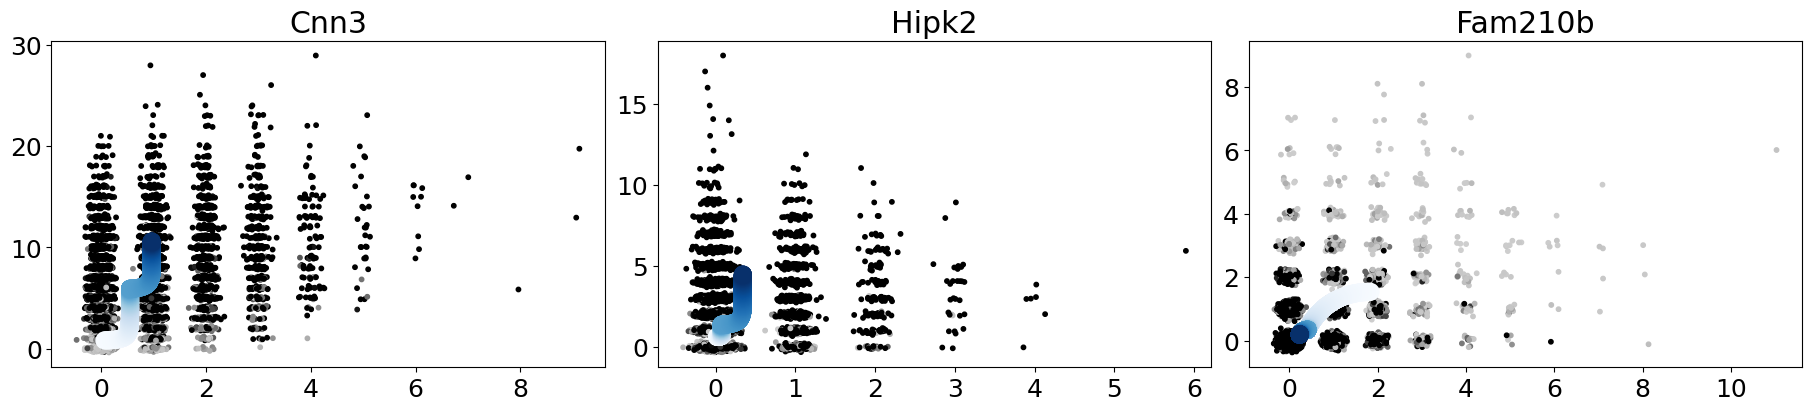

In [351]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes,cell_colors=cmap_y(cluster));

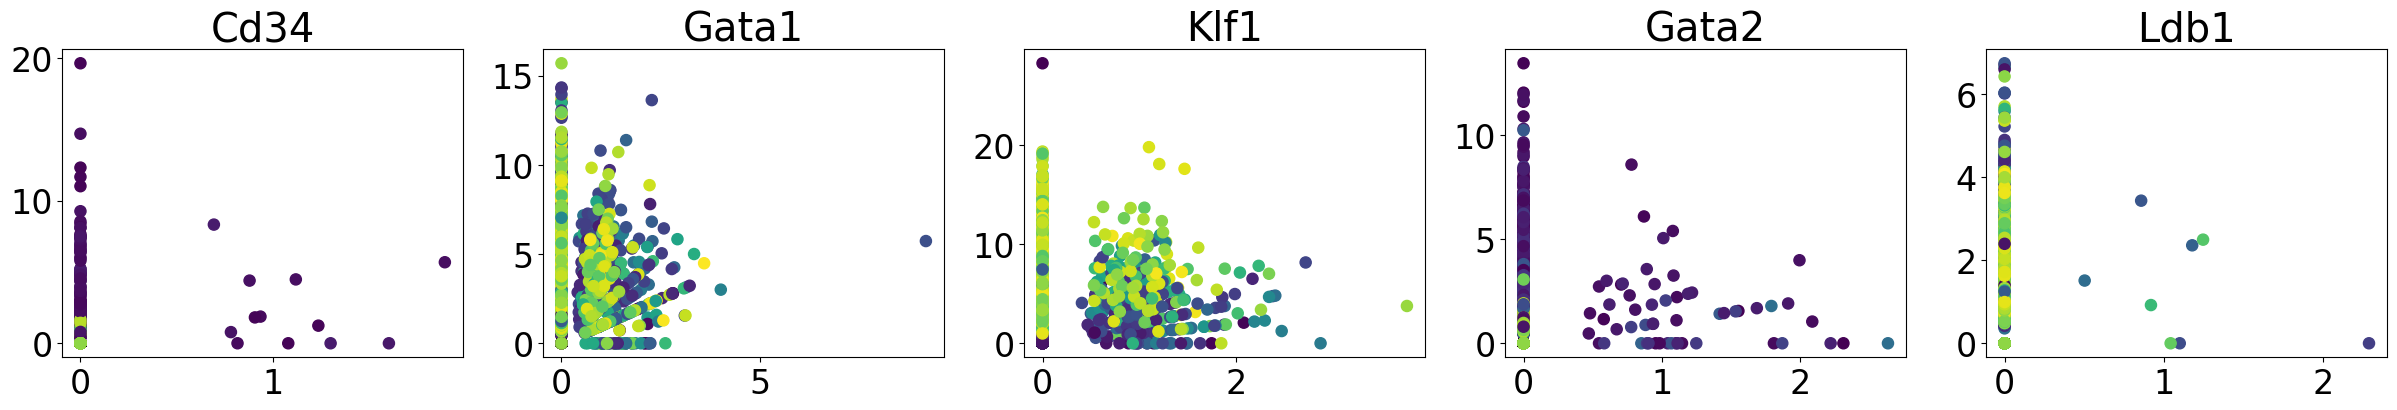

In [216]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

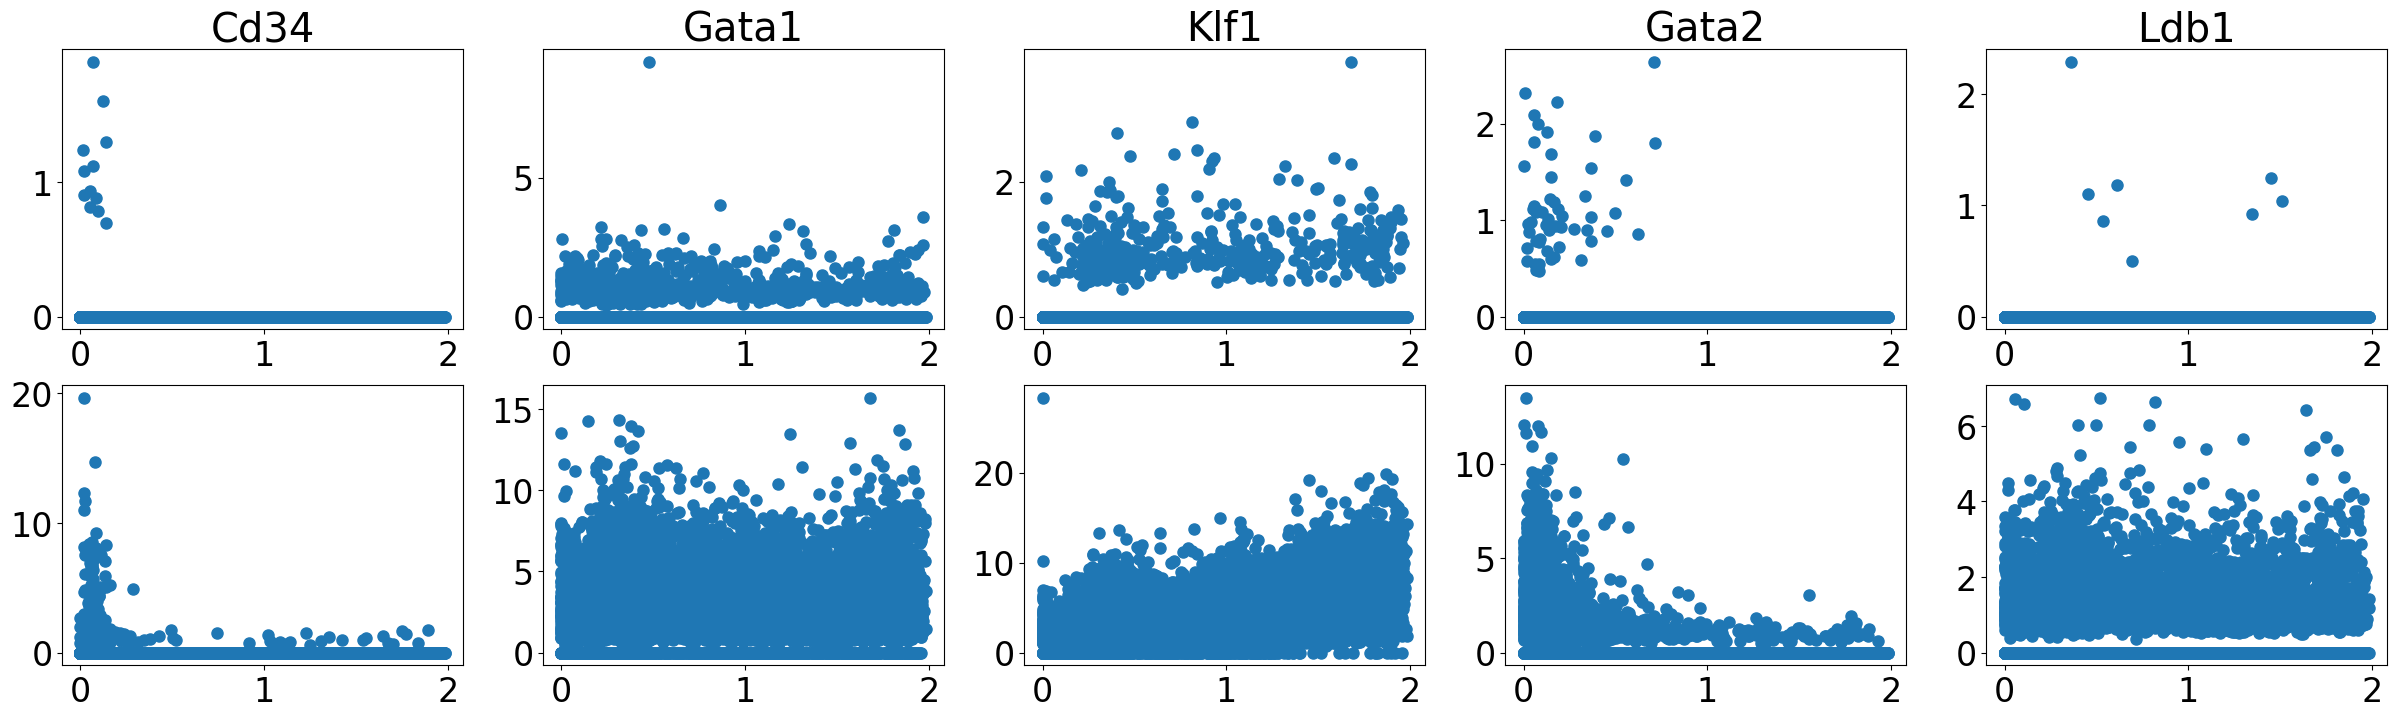

In [217]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

3


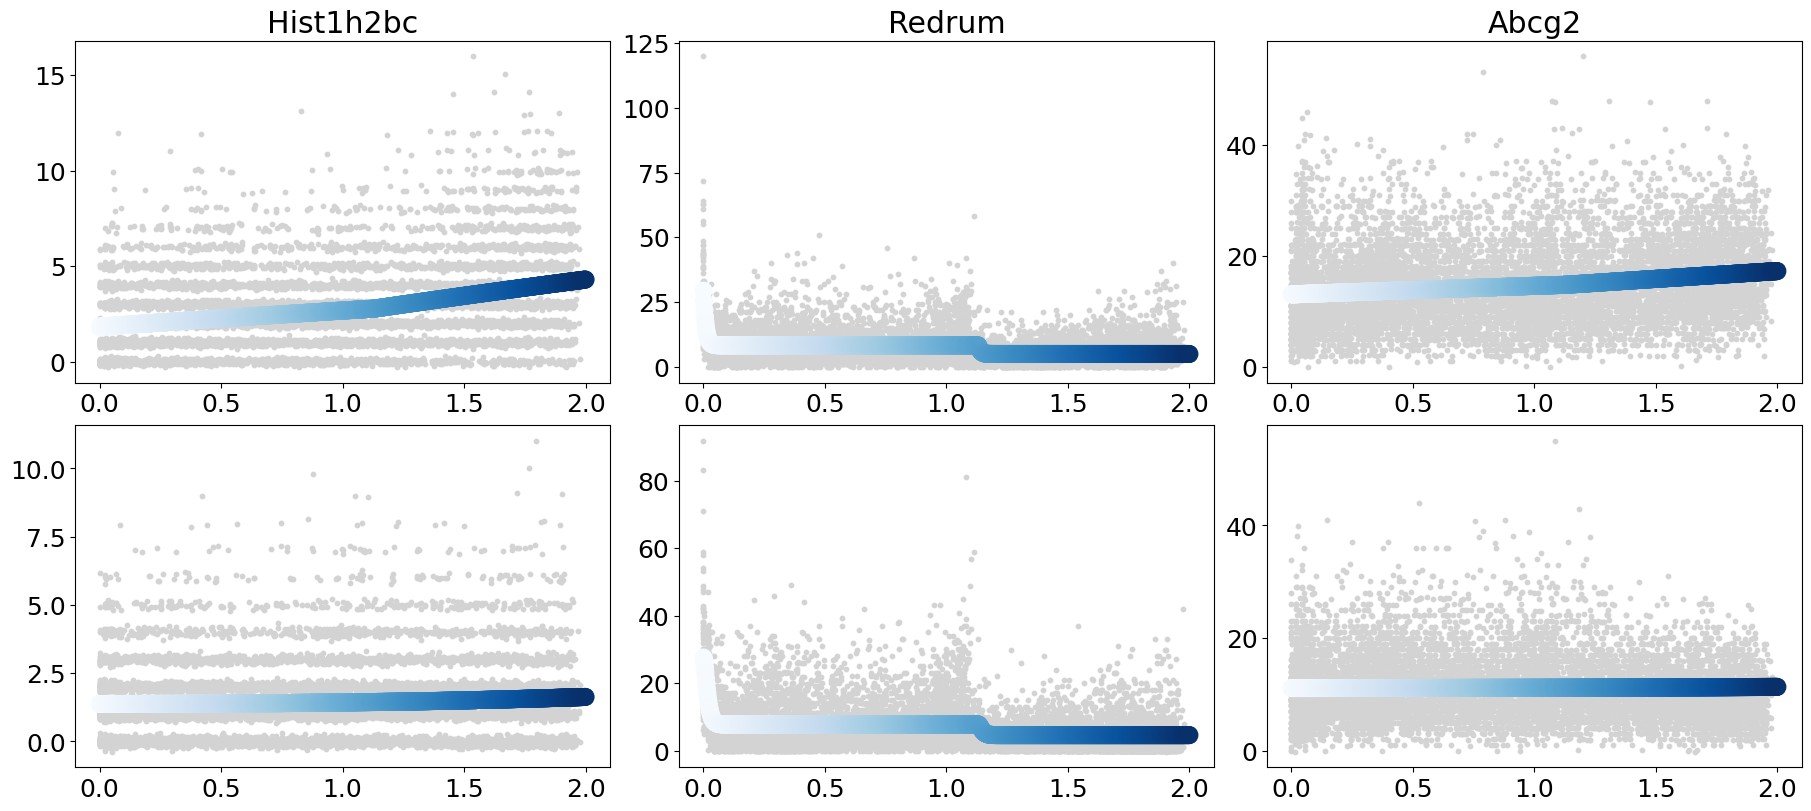

In [307]:
alpha = traj.theta[:,:3]
DE_mask = (alpha.max(1)-alpha.min(1)) > 3*np.sqrt(alpha.max(1))
print(DE_mask.sum())
DE_idx = np.arange(p)[DE_mask]
plot_y(traj,X=X,idx=DE_idx,gene_name=fitted_genes);

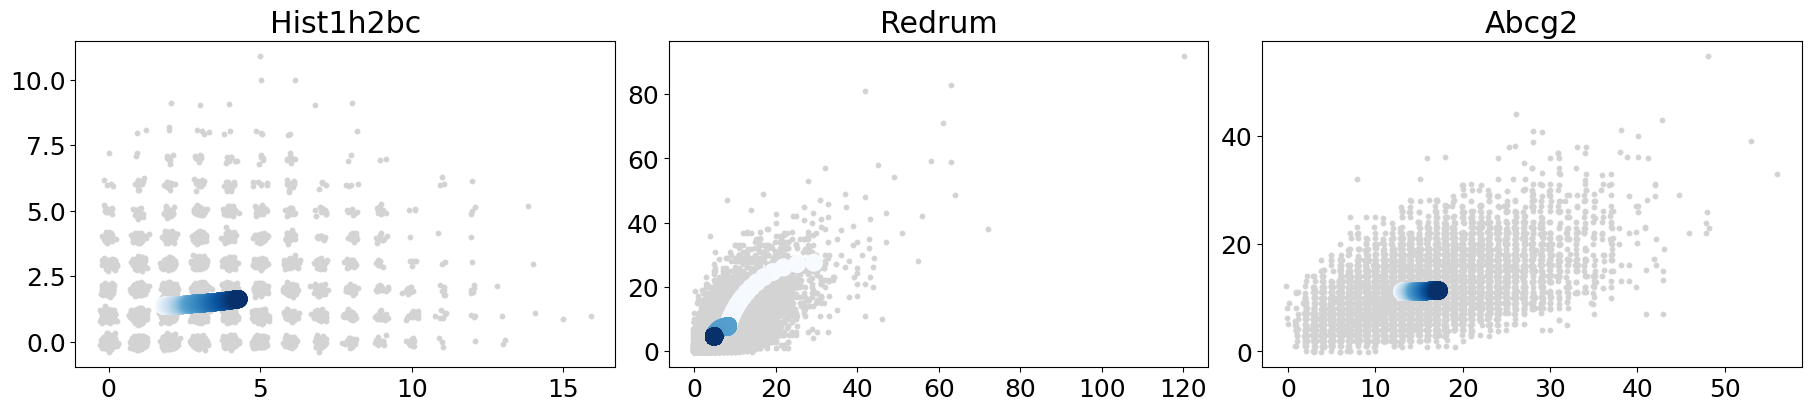

In [313]:
plot_phase(traj,X=X,idx=DE_idx,gene_name=fitted_genes);

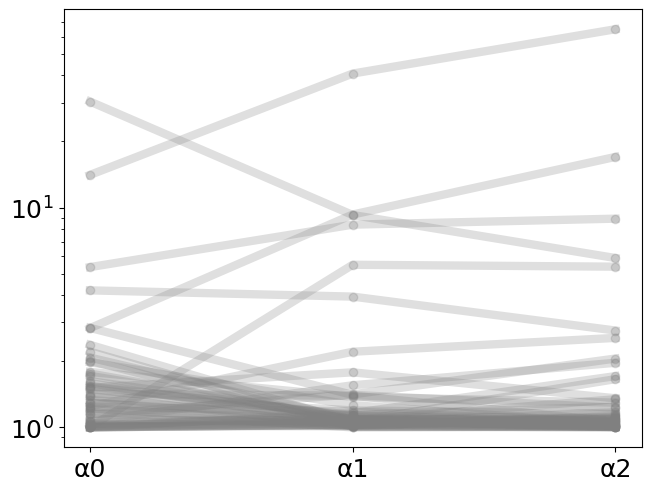

In [348]:
p = X.shape[1]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(1+traj.theta[j,[0,1,2]],'.-',color='gray',alpha=0.25)
#for j in DE_idx:
#    ax.plot(traj.theta[j,[0,1,2]],'.-',color='tab:red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
plt.yscale('log')

In [220]:
enrichr = gget.enrichr(fitted_genes,database='ontology')
enrichr

Wed Aug 16 19:39:44 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,platelet aggregation (GO:0070527),2.547613e-08,73.020528,1276.802186,"[UBASH3B, FN1, GATA1, ACTB, FERMT3]",0.000014,GO_Biological_Process_2021
1,2,homotypic cell-cell adhesion (GO:0034109),7.232139e-08,58.018648,953.951079,"[UBASH3B, FN1, GATA1, ACTB, FERMT3]",0.000020,GO_Biological_Process_2021
2,3,integrin activation (GO:0033622),1.631011e-04,141.453901,1233.639334,"[FN1, FERMT3]",0.022695,GO_Biological_Process_2021
3,4,platelet degranulation (GO:0002576),2.478449e-04,14.567493,120.949632,"[FN1, TAGLN2, RAB27B, FERMT3]",0.022695,GO_Biological_Process_2021
4,5,regulation of cell-cell adhesion mediated by i...,2.613078e-04,106.079787,875.138256,"[SKAP1, FERMT3]",0.022695,GO_Biological_Process_2021
...,...,...,...,...,...,...,...,...
561,562,negative regulation of apoptotic process (GO:0...,7.001148e-01,0.837939,0.298734,[GATA1],0.705098,GO_Biological_Process_2021
562,563,protein ubiquitination (GO:0016567),7.288322e-01,0.772384,0.244314,[PSMA2],0.732716,GO_Biological_Process_2021
563,564,negative regulation of cellular macromolecule ...,7.434598e-01,0.740423,0.219491,[RPL13A],0.746096,GO_Biological_Process_2021
564,565,negative regulation of cellular process (GO:00...,7.554685e-01,0.714823,0.200449,[COL18A1],0.756806,GO_Biological_Process_2021


In [221]:
import gget
enrichr = gget.enrichr(fitted_genes[DE_idx],database='ontology',background_list=np.array(fitted_genes).tolist())
enrichr

Wed Aug 16 19:39:45 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,cellular response to hypoxia (GO:0071456),0.030612,inf,inf,"[PSMA2, HIPK2]",0.271517,GO_Biological_Process_2021
1,2,positive regulation of transmembrane receptor ...,0.082718,11.142857,27.771559,"[RBPMS, HIPK2]",0.271517,GO_Biological_Process_2021
2,3,positive regulation of Wnt signaling pathway (...,0.082718,11.142857,27.771559,"[PSMA2, RSPO3]",0.271517,GO_Biological_Process_2021
3,4,intrinsic apoptotic signaling pathway (GO:0097...,0.183673,inf,inf,[HIPK2],0.271517,GO_Biological_Process_2021
4,5,intrinsic apoptotic signaling pathway by p53 c...,0.183673,inf,inf,[HIPK2],0.271517,GO_Biological_Process_2021
...,...,...,...,...,...,...,...,...
131,132,positive regulation of transcription by RNA po...,0.654930,1.125000,0.476131,[HIPK2],0.669702,GO_Biological_Process_2021
132,133,positive regulation of nucleic acid-templated ...,0.654930,1.125000,0.476131,[HIPK2],0.669702,GO_Biological_Process_2021
133,134,"positive regulation of transcription, DNA-temp...",0.725512,0.875000,0.280768,[HIPK2],0.736341,GO_Biological_Process_2021
134,135,"regulation of transcription, DNA-templated (GO...",0.829470,0.589286,0.110177,[HIPK2],0.835615,GO_Biological_Process_2021


## Model selection

In [138]:
clusters

AAAGATCTCTCGAA    Blood progenitors 2
AATCTCACTGCTTT    Blood progenitors 2
AATGGCTGAAGATG    Blood progenitors 2
ACACATCTGTCAAC    Blood progenitors 2
ACGACAACTGGAGG    Blood progenitors 2
                         ...         
TTTCACGACTGGTA             Erythroid3
TTTCAGTGCGAGTT             Erythroid3
TTTCGAACGGTGAG             Erythroid3
TTTCGAACTAACCG             Erythroid3
TTTCTACTTCTCTA             Erythroid3
Name: celltype, Length: 9815, dtype: category
Categories (5, object): ['Blood progenitors 1', 'Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']

In [139]:
elbo_out = []
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), clusters)):
    X_train = X[train_index]
    X_test = X[test_index]
    r=rd[train_index]/rd[train_index].mean()
    PM = PoissonMixtureSS(n_components=3,verbose=0)
    Q, elbo = PM.fit(X_train,warm_start=False,read_depth=r,epoch=10,n_init=5)
    PM.rd = rd[test_index]/rd[train_index].mean()
    elbo_out.append(PM.compute_lower_bound(X_test))
print(np.mean(elbo_out))

-95.91680886901304


In [140]:
topo1 = np.array([[0,1,2]])
tau1 = (0,1,2) # ~48 hours

elbo_out = []
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), clusters)):
    X_train = X[train_index]
    X_test = X[test_index]
    params = {'r':rd[train_index]/rd[train_index].mean()}

    traj1 = Trajectory(topo1, tau1, model="two_species_ss",verbose=0)
    traj1 = traj1.fit(X_train,warm_start=True,fit_tau=True,params=params,Q=traj.Q[train_index],parallel=True,n_threads=4,epoch=20)

    traj1.params['r'] = rd[test_index]/rd[train_index].mean()
    elbo_out.append(traj1.compute_lower_bound(X_test))
print(np.mean(elbo_out))

-94.69398117521247


In [141]:
topo_ = np.array([[0,1,2,3,4]])
tau_ = (0,1,2,3,4) # ~48 hours

elbo_out = []
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), clusters)):
    X_train = X[train_index]
    X_test = X[test_index]
    params = {'r':rd[train_index]/rd[train_index].mean()}

    traj1 = Trajectory(topo_, tau_, model="two_species_ss",verbose=0)
    traj1 = traj1.fit(X_train,warm_start=True,fit_tau=True,params=params,Q=traj.Q[train_index],parallel=True,n_threads=4,epoch=20)

    traj1.params['r'] = rd[test_index]/rd[train_index].mean()
    elbo_out.append(traj1.compute_lower_bound(X_test))
print(np.mean(elbo_out))

-93.62708481207328


In [146]:
traj_ = Trajectory(topo_, tau_, model="two_species_ss",verbose=1)
traj_ = traj_.fit(X,warm_start=True,fit_tau=True,params={'r':rd/rd.mean()},Q=traj.Q,parallel=True,n_threads=10,epoch=20)

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


In [164]:
traj_.compute_BIC(X)

-92.92013629758817

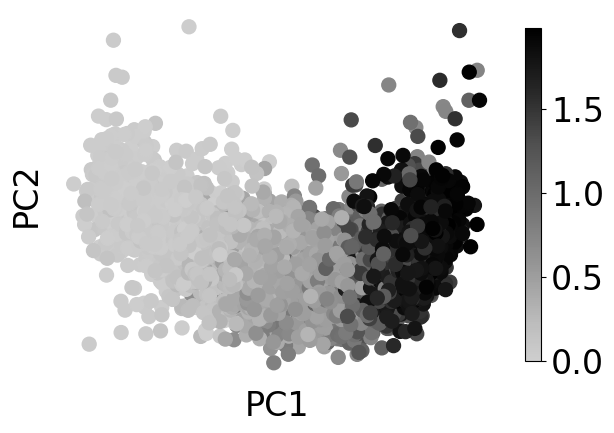

In [149]:
cmap_y = cmr.get_sub_cmap('Greys', 0.3, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj_.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

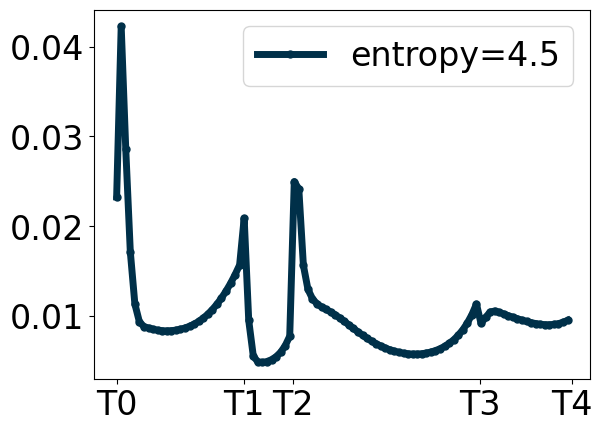

In [153]:
ax = plt.subplot()
marginal = traj_.Q.sum((0,1))/traj_.Q.sum()
ax.plot(marginal,'.-',color="#003049",linewidth=5,\
        label="entropy="+str(np.around(entropy(marginal),2)));
x_label_list = ['T0', 'T1', 'T2', 'T3', 'T4']
ax.set_xticks(traj_.tau/traj_.tau[-1]*traj_.m)
ax.set_xticklabels(x_label_list);
ax.legend()

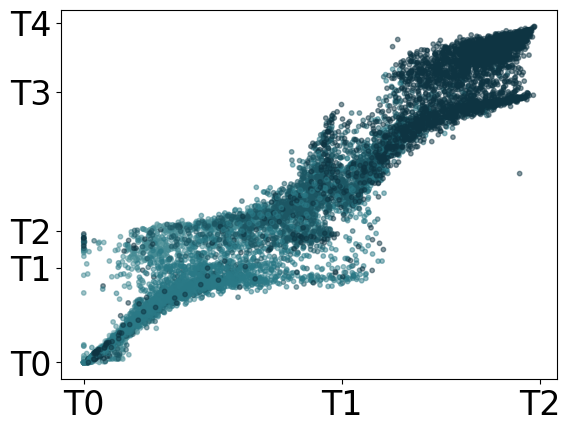

In [162]:
ax = plt.subplot()
ax.scatter(traj.Q[:,0]@traj.t,traj_.Q[:,0]@traj_.t,s=10,c=cell_colors);
x_label_list = ['T0', 'T1', 'T2']
ax.set_xticks(traj.tau)
ax.set_xticklabels(x_label_list);
y_label_list = ['T0', 'T1', 'T2', 'T3', 'T4']
ax.set_yticks(traj_.tau)
ax.set_yticklabels(y_label_list);